## PyTorch Conditional GAN

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

 # data loader function

In [2]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../input/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
dataset = FashionMNIST()
dataset[0][0]

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

# Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [7]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Loss Optimizers

In [8]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [9]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data[0]

In [10]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data[0]

Starting epoch 0...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


g_loss: 4.356785297393799, d_loss: 0.18666613101959229


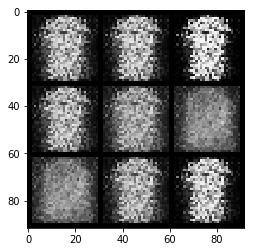

Starting epoch 1...
g_loss: 4.277082443237305, d_loss: 0.14595071971416473


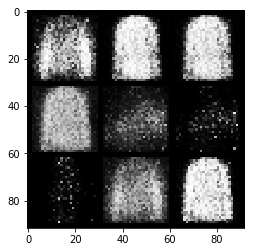

Starting epoch 2...
g_loss: 3.96000599861145, d_loss: 0.5927190780639648


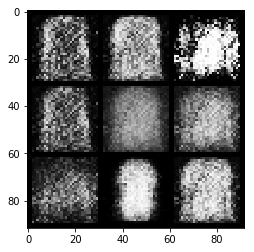

Starting epoch 3...
g_loss: 3.5106449127197266, d_loss: 0.19194826483726501


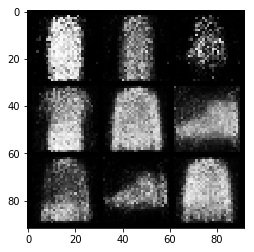

Starting epoch 4...
g_loss: 2.3803744316101074, d_loss: 0.7386077046394348


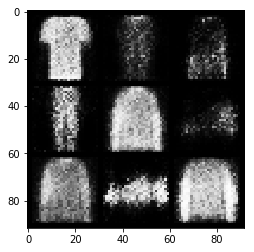

Starting epoch 5...
g_loss: 2.3901517391204834, d_loss: 0.6714112162590027


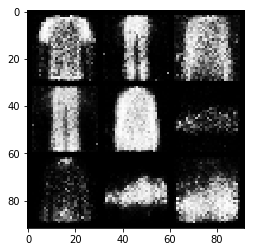

Starting epoch 6...
g_loss: 2.1872153282165527, d_loss: 0.5619909763336182


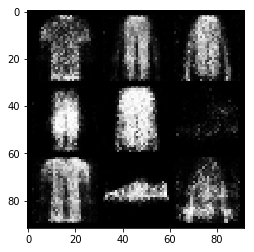

Starting epoch 7...
g_loss: 2.2976090908050537, d_loss: 0.5437521934509277


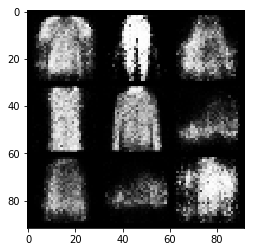

Starting epoch 8...
g_loss: 1.6556622982025146, d_loss: 0.7493007183074951


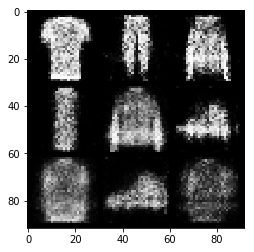

Starting epoch 9...
g_loss: 1.9748753309249878, d_loss: 0.9957867860794067


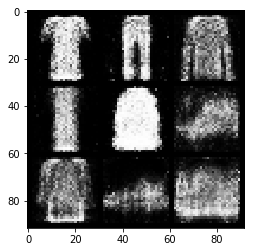

Starting epoch 10...
g_loss: 1.4605152606964111, d_loss: 0.9430602788925171


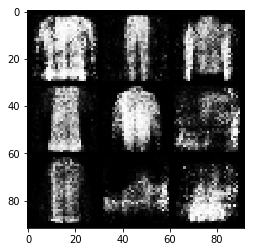

Starting epoch 11...
g_loss: 1.8148595094680786, d_loss: 0.6825506687164307


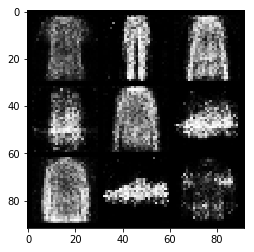

Starting epoch 12...
g_loss: 1.952599048614502, d_loss: 0.6052872538566589


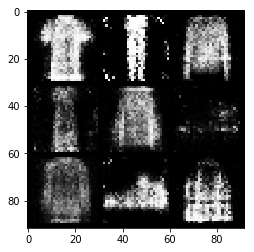

Starting epoch 13...
g_loss: 1.6873831748962402, d_loss: 0.6417231559753418


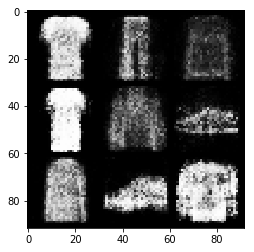

Starting epoch 14...
g_loss: 1.9217901229858398, d_loss: 0.5765367746353149


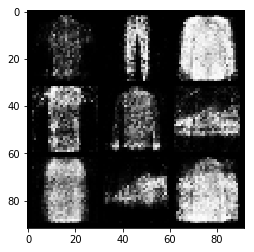

Starting epoch 15...
g_loss: 1.2147496938705444, d_loss: 1.012403964996338


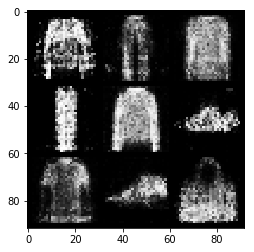

Starting epoch 16...
g_loss: 1.4884330034255981, d_loss: 1.2099875211715698


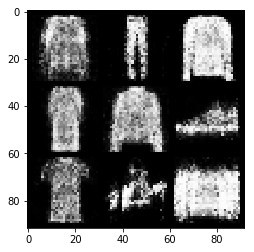

Starting epoch 17...
g_loss: 1.298218846321106, d_loss: 0.9122105240821838


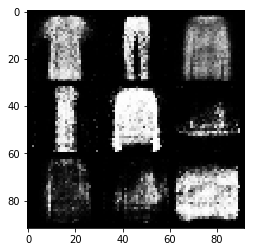

Starting epoch 18...
g_loss: 1.647831916809082, d_loss: 1.0764896869659424


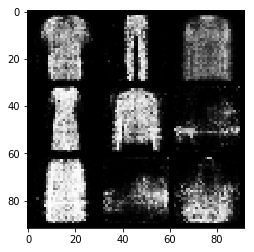

Starting epoch 19...
g_loss: 1.4322253465652466, d_loss: 1.055999517440796


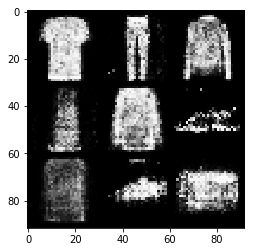

Starting epoch 20...
g_loss: 1.6621198654174805, d_loss: 0.7568349838256836


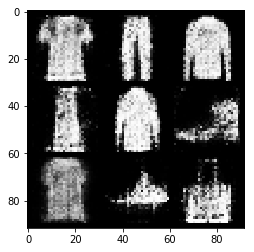

Starting epoch 21...
g_loss: 1.254940390586853, d_loss: 1.1506574153900146


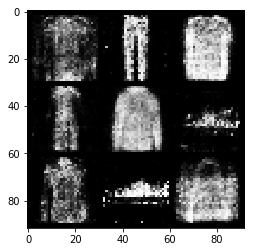

Starting epoch 22...
g_loss: 1.2345370054244995, d_loss: 0.9246429800987244


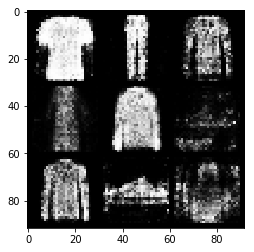

Starting epoch 23...
g_loss: 1.378284215927124, d_loss: 1.3049964904785156


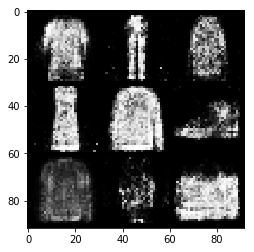

Starting epoch 24...
g_loss: 1.2159857749938965, d_loss: 1.0924872159957886


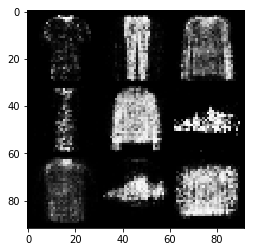

Starting epoch 25...
g_loss: 1.047853708267212, d_loss: 1.035159707069397


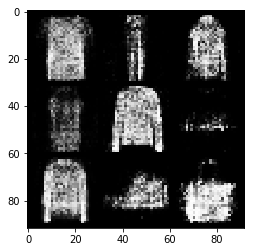

Starting epoch 26...
g_loss: 1.1423951387405396, d_loss: 1.0237343311309814


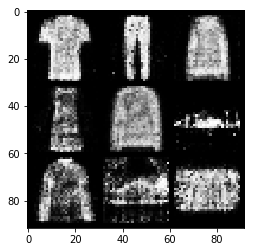

Starting epoch 27...
g_loss: 1.4091192483901978, d_loss: 1.3257664442062378


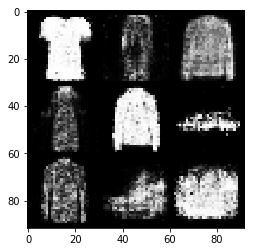

Starting epoch 28...
g_loss: 1.2954450845718384, d_loss: 1.0231329202651978


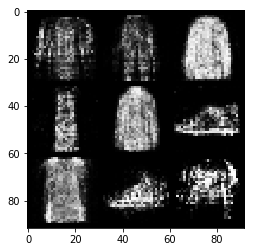

Starting epoch 29...
g_loss: 1.2456648349761963, d_loss: 0.975037693977356


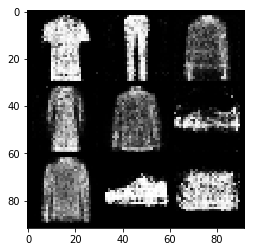

In [11]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## Results

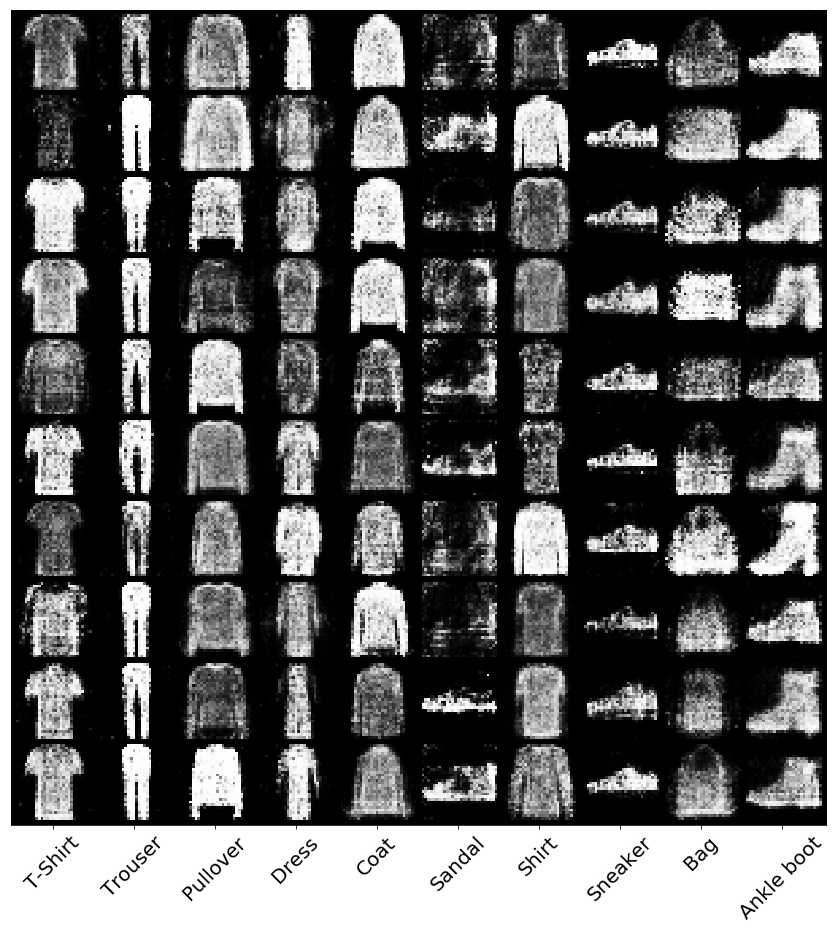

In [12]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)
